# Humanitarian Crisis in Ukraine - NLP Topic Modeling
## Svitlana Omural, March 17 2023

I use topic modeling to extract keywords associated with a type of infrasructure from the report narratives. 

In [1]:
import pandas as pd

df_ukr = pd.read_csv("acled_data.csv")
columns = ['event_date', 'event_type', 'sub_event_type', 'admin1', 'admin2', 'admin3', 'location', 'latitude', 
           'longitude', 'notes', 'fatalities', 'timestamp']
df_ukr = df_ukr[columns]

After careful inspection of the reports, I found that only reports on such events as "Air/drone strike", "Remote explosive/landmine/IED", "Shelling/artillery/missile attack", and "Looting/property destruction" mention some kind of infrastructure. So, I will only include those events in the following analysis.

In [2]:
df = df_ukr.loc[(df_ukr['sub_event_type'] == 'Air/drone strike') | 
                (df_ukr['sub_event_type'] == 'Remote explosive/landmine/IED') | 
                (df_ukr['sub_event_type'] == 'Shelling/artillery/missile attack') |
                (df_ukr['sub_event_type'] == 'Looting/property destruction')]

## First approach: clustering
First, I use clustering, a common unsupervised learning technique. Reports are clustered together to generate groups of reports that discuss similar topics.

## Pre-processing and feature extraction

To obtain meaningful results, it is essential to preprocess input data. I utilize a widely used NLP technique called "bag of words" to tokenize, remove stop words, and lemmatize the data. I use regular expressions and spaCy for that. 

In [3]:
import spacy
nlp = spacy.load('en_core_web_sm', disable=['parser','ner','textcat'])

print(nlp.pipe_names)

['tok2vec', 'tagger', 'attribute_ruler', 'lemmatizer']


First, I build a custom tokenizer/lemmatizer. I use regular expression to extract alphabetic characters and change them to lower case, strip out punctuation and spaces from documents. I only keep nouns and adjectives because they define the infrastructure mentioned in reports. I also filter out the location of the event from the text.

In [4]:
location = set(df['admin1']).union(df['admin2'], df['admin3'], df['location'])
exclude_location = {str(s).lower() for s in location}

In [5]:
import re

In [6]:
def my_lemmatizer(doc, exclude_words=[]):
    if isinstance(doc, float): # check if doc is NaN
        return []
    doc_cleaned = ' '.join(re.findall(r'\b[a-zA-Z\']+\b', doc.lower()))
    lemmas = [w.lemma_.lower() for w in nlp(doc_cleaned) 
              if w.lemma_ not in ['_', '.', '-PRON-'] and w.pos_ in ['NOUN', 'ADJ']]
    lemmas = [lemma for lemma in lemmas if lemma not in exclude_words]
    return lemmas

In [7]:
stopwords = spacy.lang.en.stop_words.STOP_WORDS

To get meaningful clusters, I added additional stopwords that do not identify infrastructure. 

In [8]:
# Remove words unrelated to infrastructure types
from spacy.lang.en.stop_words import STOP_WORDS

stopwords = STOP_WORDS.union({'equipment', 'fire', 'soldier', 'district', 'result', 'military', 'region', 'civilian', 
            'people', 'militia', 'dpr', 'lpr', 'mortar', 'position', 'community', 'mlrs', 'artillery', 'private', 
            'rebel', 'fatality', 'launcher', 'grenade', 'arm', 'small', 'river', 'order', 'area', 'right', 'troop',
            'rocket', 'property', 'strike', 'petrovskyi', 'azovstal', 'weapon', 'explosion', 'burst', 'shot', 'total', 
            'smm', 'osce', 'attack', 'missile', 'displacement', 'damaging', 'object', 'hromada', 'critical', 'shelling', 
            'city', 'local', 'location', 'complex', 'woman', 'household', 'grad', 'donbass', 'territorial', 'himar', 
            'village', 'supply', 'settlement', 'direction', 'explosive', 'week', 'movement', 'partisan', 'air', 
            'serviceman', 'operation', 'event', 'day', 'concentration', 'manpower', 'night', 'drone', 'city'
            'airstrike', 'child', 'c', 'offensive', 'uragan', 'person', 'high', 'unspecified', 'gun', 'machine', 
            'heavy', 'governmental', 'injury', 'evacuation', 'clash', 'cannon', 'multiple', 'cluster', 'munition', 
            'ammunition', 'base', 'group', 'column', 'bomb', 'report', 'control', 'employee', 'territory', 'airstrike', 
            'armed', 'town', 'regional', 'unit', 'tank', 'time', 'outskirt', 'place', 'oblast', 'command', 'system', 
            'damage', 'source', 'point', 'ukraine', 'convoy', 'emergency', 'frontline', 'journalist', 'distribution', 
            'guard', 'loss', 'source', 'place', 'worker', 'kuibyshivskyi', 'center', 'state', 'destruction', 
            'infrastructure', 'defence', 'member', 'seizure', 'shell', 'tochka', 'number', 'smerch', 'administration', 
            'unidentified', 'marhanet', 'battalion', 'department', 'personnel', 'month', 'station', 'service', 
            'separate', 'officer', 'policeman', 'size', 'sea', 'anti', 'morning', 'dead', 'device', 
            'building','tokmachka', 'velyka', 'tyshky', 'remnant', 'kirovskyi', 'foce', 'mortart', 'lenina', 'caliber', 
            'imeni', 'shakhta', 'central', 'komsomolet', 'kreminet', 'balka', 'large', 'kirovskyi', 'caliber', 'buda', 
            'pole', 'pody', 'scherbaky', 'kozachok', 'nyva', 'different', 'type', 'staryi', 'debris', 'verkhniy', 
            'assault', 'ground', 'volunteer', 'fragmentation', 'forest', 'depot', 'ivano', 'stronghold', 'defense', 
            'armored', 'post', 'ammo', 'depot', 'landmine', 'voroshilovsky', 'mala', 'armoured', 'infantry', 'carrier', 
            'combat', 'aerial', 'unmanned', 'occupation', 'driver', 'head', 'government', 'man', 'south', 'fighter', 
            'mi', 'helicopter', 'phosphorus', 'land', 'home', 'jet', 'blackout', 'pilot', 'aircraft', 'old', 'ied', 
            'mayor', 'ifvs', 'casulatie', 'projectile', 'leninskyi', 'police', 'year', 'aid', 'piece', 'crossing', 
            'advance', 'advancement', 'dnieper', 'howitzer', 'self', 'pickup', 'fighting', 'plane', 'ruski', 'dozen', 
            'checkpoint', 'exact', 'nearby', 'inhulet', 'resistance', 'official', 'u', 'rih', 'evening',
            'shahed', 'radar', 'machinegun', 'regular', 'headquarters', 'urahan', 'unexploded', 'border', 'iskander', 
            'repair', 'shevchenkivskyi', 'kyivskyi', 'information', 'facility', 'office', 'barrel', 'warehouse', 
            'vehicle', 'russian', 'ukrainian', 'force', 'unknown', 'casualty', 'novhorod', 'siverskyi', 'kinski', 
            'rosdory', 'civil', 'resident', 'automatic'}) 

After pre-processing the text, the next step is to vectorize it. I use the CountVectorizer method to obtain a count of the words in the text. Then, I use the TfidfTransformer method to weight the words by their inverse document frequency.

In [9]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from scipy.sparse import coo_matrix

In [10]:
cv = CountVectorizer(tokenizer=lambda x: my_lemmatizer(x, exclude_words=exclude_location), 
                     stop_words=list(stopwords),
                     #ngram_range=(2,2),
                     min_df=10, max_df=800,
                     token_pattern=None)
counts = cv.fit_transform(df['notes'])

tf = TfidfTransformer()
matrix = tf.fit_transform(counts)

/home/jovyan/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['headquarter', 'phosphoru'] not in stop_words.
  warnings.warn(


## $K$-means clustering 

To identify "topics of conversation" in the data, I employ the $k$-means clustering algorithm. It groups documents together based on their vector similarity, where the smaller the difference of their vectors, the closer they are. $k$-means clustering is an unsupervised learning algorithm since the optimal number of clusters is unknown. I tried different numbers of clusters from 5-15. Then I compared their silhouette scores and examined the top words in the clusters to check if there is a significant overlap of common words. I found that 7 is a good number of clusters in this case.

In [11]:
from sklearn.cluster import KMeans

In [12]:
number_of_clusters = 7

kmc_7 = KMeans(n_clusters=number_of_clusters, n_init=3, random_state=117)
kmc_7.fit(matrix)

KMeans(n_clusters=7, n_init=3, random_state=117)

To identify the main themes of each cluster, I find the center of each cluster and sort the coordinates to determine the largest components of each vector. Then, I combine those largest vector components with the corresponding feature names to extract the most important words for each cluster.

In [13]:
# get coordinates of each center of the clusters
kmc_7.cluster_centers_

array([[3.42395398e-04, 4.57919340e-04, 9.52245599e-04, 3.19118619e-04,
        1.26787597e-03, 2.73123544e-04, 6.99102912e-04, 5.21046569e-04,
        4.10874478e-04, 4.08435354e-04, 3.11582696e-04, 5.13593097e-04,
        2.30819045e-03, 4.79353557e-04, 6.39093442e-04, 9.31450818e-05,
        5.29087020e-04, 3.24117836e-04, 4.18150277e-04, 2.66197848e-04,
        2.68915537e-04, 2.49026720e-04, 3.34730244e-04, 1.17322902e-03,
        1.56636849e-03, 1.36481221e-03, 3.00541502e-04, 3.82177231e-04,
        6.92886060e-04, 8.84029910e-04, 1.53094893e-03, 7.00554605e-04,
        2.72369281e-05, 6.84790796e-04, 3.42767782e-04, 9.43686995e-04,
        3.16306292e-04, 1.34103912e-03, 5.09237392e-04, 6.62808420e-04,
        3.89701674e-04, 5.14636407e-04, 3.83221165e-04, 4.54888206e-04,
        4.19676558e-04, 2.04409280e-03, 3.35965214e-04, 2.55802300e-04,
        3.87117244e-04, 4.48225195e-04, 6.31180628e-04, 5.54659307e-04,
        7.09199425e-04, 1.78974044e-03, 7.90223879e-04, 5.581884

In [14]:
import numpy as np

number_of_top_words = 3

# sort the coordinates to find the largest components of each vector
cluster_words = np.argsort(kmc_7.cluster_centers_, axis=1)

# extract a list of words to look up a word, given its index in the vector
terms = cv.get_feature_names_out()

top_words = set()

for i in range(number_of_clusters):
    print(f'Cluster {i}: ')
    print(' '.join([terms[k] for k in cluster_words[i][-number_of_top_words:]]),'\n')
    top_words = top_words.union([terms[k] for k in cluster_words[i][-number_of_top_words:]])
    
top_words = sorted(list(top_words))

Cluster 0: 
zalizna bridge power 

Cluster 1: 
gas kindergarten residential 

Cluster 2: 
apartment residential house 

Cluster 3: 
ambulance house car 

Cluster 4: 
school residential hospital 

Cluster 5: 
house residential school 

Cluster 6: 
line bridge railway 



By analyzing these words, I update my list of stopwords and reprocess the resulting new bag of words matrix.

To evaluate the quality of my clustering, I use "silhouette score" in scikit-learn. 

In [15]:
#combine counts with cluster labels to create a pandas DataFrame
word_df = pd.DataFrame(counts.toarray(), columns=terms)[top_words]
word_df['Cluster'] = kmc_7.labels_.tolist()

In [16]:
word_df.head()

,ambulance,apartment,bridge,car,gas,hospital,house,kindergarten,line,power,railway,residential,school,zalizna,Cluster
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [17]:
from sklearn.metrics import silhouette_score

print(f'Clusters: {number_of_clusters}  Silhouette score: {silhouette_score(matrix, word_df["Cluster"])}')

Clusters: 7  Silhouette score: 0.9119178167296846


The silhouette score is close to 1, indicating that the object is well-matched to its own cluster and poorly matched to neighboring clusters.

To get more insight into the clustering, I visualize the results. First, let's see how many documents (reports) are in each cluster.    

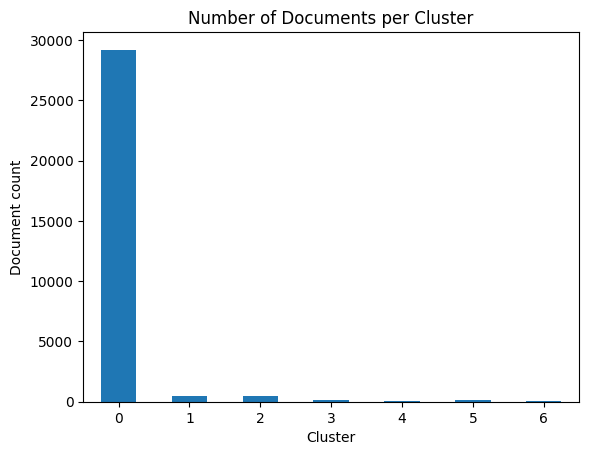

In [18]:
word_df.groupby('Cluster').count()[top_words[0]].\
    plot.bar(rot=0).\
    set(ylabel='Document count',
    title='Number of Documents per Cluster');

Cluster 0 has disproportionally high number of documents.

Let's visualize the frequency of the "top words" within each cluster.

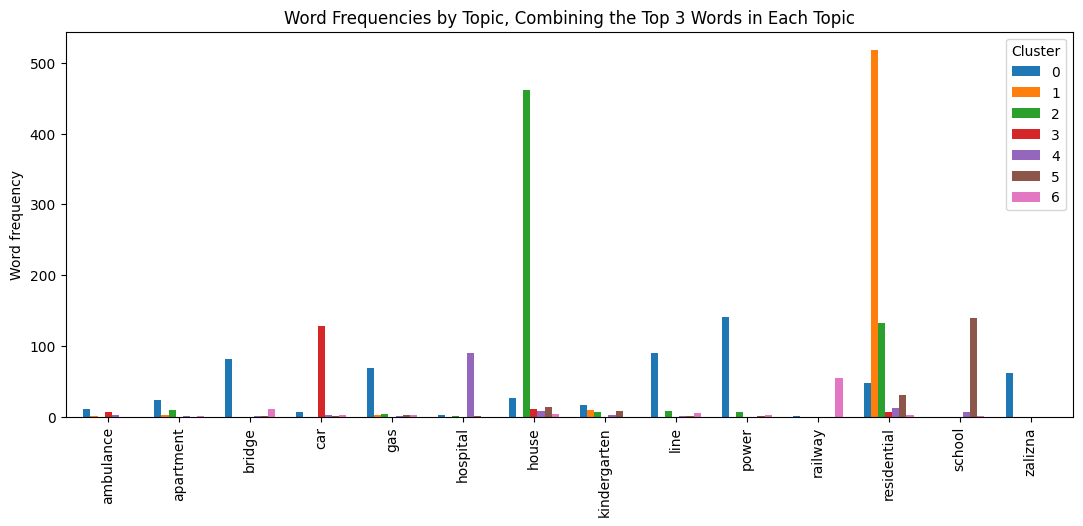

In [19]:
word_df.groupby('Cluster').sum().transpose().\
    plot.bar(figsize=(13,5), width=0.7).\
    set(ylabel='Word frequency', 
    title=f'Word Frequencies by Topic, Combining the Top {number_of_top_words} Words in Each Topic');

The model produced 7 clusters: power, shelter, transport, health, education, logistics infrastructure. There are 2 shelter clusters. Setting different number of clusters does not change that. Disproportionally large number of residential building and houses have been damaged. There's also some overlapping of common words because multiple infrastructures can be damaged in a single attack. 
Note: 'zalizna' means railway in Ukrainian.

## Second Approach: Latent Dirichlet allocation (LDA)

The clustering approach that utilizes values from the TfidfTransformer relies on the similarity of the associated vectors, with documents being considered similar if their vectors are close to each other. However, this method assumes that exactly same words are used in a particular topic.

On the other hand, the LDA model assumes that documents are generated word by word. For every possible word, a topic is chosen based on a hidden probability distribution over the set of topics, and then a specific word is chosen based on another hidden probability distribution over a set of words for that topic. The LDA machine learning algorithm's training process aims to construct these unknown probability distributions.

I use the gensim library and its LdaModel class.

In [20]:
import gensim

In [21]:
notes_text = df[['notes']]
notes_text.head()

,notes
13,"On 27 January 2023, Russian forces shelled nea..."
14,"On 27 January 2023, Russian forces shelled nea..."
15,"On 27 January 2023, Russian forces shelled nea..."
16,"On 27 January 2023, Russian forces shelled nea..."
17,"On 27 January 2023, Russian forces shelled nea..."


In [22]:
notes_text.columns

Index(['notes'], dtype='object')

In [23]:
texts = notes_text.notes.values.tolist()

In [24]:
texts[:10]

['On 27 January 2023, Russian forces shelled near Avdiivka, Donetsk. Casualties unknown.',
 'On 27 January 2023, Russian forces shelled near Bachivsk, Sumy. Casualties unknown.',
 'On 27 January 2023, Russian forces shelled near Berdychi, Donetsk. Casualties unknown.',
 'On 27 January 2023, Russian forces shelled near Berestove, Kharkiv. Casualties unknown.',
 'On 27 January 2023, Russian forces shelled near Bila Hora, Donetsk. Casualties unknown.',
 'On 27 January 2023, Russian forces shelled near Bilyi Kolodiaz, Kharkiv. Casualties unknown.',
 'On 27 January 2023, Russian forces shelled near Blahodatne, Donetsk. Casualties unknown.',
 'On 27 January 2023, Russian forces shelled near Bohoiavlenka, Donetsk. Casualties unknown.',
 'On 27 January 2023, Russian forces shelled near Budarky, Kharkiv. Casualties unknown.',
 'On 27 January 2023, Russian forces shelled near Burhunka, Kherson. Casualties unknown.']

Again, I preprocess the data by removing stop words and event location, keeping nouns and adjectives, and lemmatizing the text of the reports.  

In [25]:
from spacy.lang.en.stop_words import STOP_WORDS

stopwords = STOP_WORDS.union({'arm', 'attack', 'casualty', 'clash', 'district', 'fatality', 'force', 'local', 
            'military', 'militia', 'people', 'position', 'region', 'result', 'russian', 'small', 'soldier', 'total', 
            'ukrainian', 'unknown', 'weapon', 'air', 'airstrike', 'armed', 'artillery', 'azovstal', 'causality', 
            'center', 'city', 'concentration', 'day', 'explosion', 'grenade', 'heavy', 'launcher', 'location', 
            'manpower', 'missile', 'mortar', 'rocket', 'shot', 'strike', 'unspecified', 'area', 'bomb', 'border', 
            'dpr', 'drone', 'emergency', 'grad', 'guard', 'gun', 'oblast', 'person', 'service', 'serviceman', 'size', 
            'state', 'tank', 'troop', 'unit', 'administration', 'ammunition', 'event', 'government', 'group', 'injury', 
            'man', 'movement', 'partisan', 'property', 'report', 'town', 'unidentified', 'child', 'community', 
            'convoy', 'explosive', 'occupation', 'order', 'personnel', 'territorial', 'village', 'woman', 'battalion', 
            'cluster', 'damage', 'damaging', 'defence', 'direction', 'journalist', 'lpr', 'munition', 'number', 
            'petrovskyi', 'resident', 'shell', 'shelling', 'territory', 'control', 'destruction', 'device', 
            'equipment', 'month', 'source', 'company', 'displacement', 'employee', 'enterprise', 'evacuation', 'head', 
            'loss', 'morning', 'offensive', 'official', 'settlement', 'aid', 'dead', 'high', 'old', 'place', 'police', 
            'policeman', 'regional', 'year', 'column', 'command', 'headquarters', 'himar', 'humanitarian', 'night', 
            'right', 'separate', 'system', 'ukraine', 'uragan', 'worker', 'kirovskyi', 'rise', 'frontline', 'multiple',
            'mayor', 'supply', 'black', 'sea', 'building', 'civil', 'civilian', 'infrastructure', 'aerial', 'armored', 
            'cannon', 'carrier', 'combat', 'counter', 'depot', 'fighting', 'fire', 'ground', 'infantry', 'information', 
            'komsomolet', 'kuibyshivskyi', 'leninskyi', 'mala', 'mlrs', 'radar', 'remnant', 'rih', 'self', 'smerch', 
            'time', 'tokmachka', 'type', 'u', 'unmanned', 'week', 'balka','base', 'boarding', 'c', 'ceramic', 'concert', 
            'deposit', 'facility', 'forester', 'home', 'howitzer', 'likely', 'member', 'michurin', 'object', 'pickup', 
            'set', 'shahed', 'special', 'submarine', 'target', 'unclear', 'velyka', 'airbome', 'appliance', 'assailant', 
            'axis', 'coast', 'defense', 'furniture', 'goal', 'helicopter', 'hromada', 'leadership', 'multi', 'numerous', 
            'pig', 'yasna', 'basement', 'buda', 'effect', 'ivano', 'kilometer', 'kozachok', 'kremyanet', 'kyivsjyi', 
            'landmine', 'nona', 'nyva', 'odessa', 'patrol', 'pier', 'pole', 'positiosn', 'ammo', 'moldovan', 'millennial', 
            'platoon', 'box', 'spirit', 'work', 'story', 'boyaro', 'victim', 'non', 'point', 'deployment', 'tanker', 
            'research', 'temporary', 'resupply', 'airborne', 'functioning', 'kyivski', 'ammonium', 'launchersat', 
            'inhulet', 'kamikaze', 'marhanet', 'maritime', 'mental', 'novobavarrskyi', 'prechystivkar', 'redut', 'craft',
            'repelent', 'sailor', 'able', 'accident', 'bomber', 'hardware', 'khakiv', 'killing', 'locality', 'nemyshlyan', 
            'officer', 'pidyomnyy', 'rest', 'batch', 'bmp', 'committee', 'karlivske', 'kyivskyi', 'main', 'portuguese', 
            'saltivka', 'znob', 'fleet', 'international', 'legion', 'liter', 'pohorilove', 'reservoir', 'spg', 
            'berezhehuvata', 'tpp'})

In [26]:
def my_lemmatizer(doc, exclude_words=[], stopwords=stopwords):
    if isinstance(doc, float): # check if doc is NaN
        return []
    if isinstance(doc, list):
        # apply the function to each element in the list
        return [my_lemmatizer(d, exclude_words=exclude_words) for d in doc]
    doc_cleaned = ' '.join(re.findall(r'\b[a-zA-Z\']+\b', doc.lower()))
    lemmas = [w.lemma_.lower() for w in nlp(doc_cleaned) 
              if w.lemma_ not in ['_', '.', '-PRON-'] and w.pos_ in ['NOUN', 'ADJ'] and w.lemma_ not in stopwords]
    lemmas = [lemma for lemma in lemmas if lemma not in exclude_words]
    return lemmas

processed_text = my_lemmatizer(texts, exclude_words=exclude_location)

Let's compare one of the original reviews to the processed text.

In [27]:
texts[0]

'On 27 January 2023, Russian forces shelled near Avdiivka, Donetsk. Casualties unknown.'

In [28]:
print(processed_text[0])

[]


To create the "bag of words", I assemble the overall vocabulary/dictionary of words and then create the word count vectors.

In [29]:
# Assemble the overall vocabulary/dictionary of words
dictionary = gensim.corpora.Dictionary(processed_text)
print(f'Number of unique tokens: {len(dictionary)}')

Number of unique tokens: 1309


In [30]:
# Create the word count vectors
corpus = [dictionary.doc2bow(t) for t in processed_text]

I built LDA models with different numbers of topics from 5-10, and found that 5 topics produces the highest coherence score and least overlapping of the top words.  

Let's examine the five topics and get the relative weight of how much each of the topic's top words contribute to that topic.  

In [31]:
num_topics = 5

lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus, 
                                            id2word=dictionary,
                                            num_topics=num_topics, 
                                            random_state=117, update_every=1,
                                            chunksize=1500, 
                                            passes=5, iterations=10,
                                            alpha='asymmetric', eta=1/100,
                                            per_word_topics=True)

In [32]:
from pprint import pprint

pprint(lda_model.print_topics(num_words=3))

[(0, '0.472*"residential" + 0.110*"school" + 0.094*"car"'),
 (1, '0.353*"vehicle" + 0.188*"station" + 0.152*"line"'),
 (2, '0.733*"kindergarten" + 0.121*"clinic" + 0.024*"outpatient"'),
 (3, '0.858*"house" + 0.129*"private" + 0.000*"harvested"'),
 (4, '0.001*"automobile" + 0.001*"harvested" + 0.001*"budling"')]


The model produced 5 somewhat well-defined topics that define infrastructure as: shelter, education, health, agriculture. Similar to $k$-means clustering, there are 2 topics definining shelter. 

Let's look the topics the LDA model found for a particular document and the proportion of the document associated with that topic.  

In [33]:
lda_model.get_document_topics(corpus[0])

[(0, 0.3328376),
 (1, 0.22998513),
 (2, 0.175693),
 (3, 0.14213863),
 (4, 0.119345635)]

Let's extract the dominant topic (and percentage) for each of the reviews in the data.

In [34]:
def get_main_topic_df(model, bow, texts):
    topic_list = []
    percent_list = []
    keyword_list = []
    
    for wc in bow:
        topic, percent = sorted(model.get_document_topics(wc), key=lambda x: x[1], reverse=True)[0]
        topic_list.append(topic)
        percent_list.append(round(percent, 3))
        keyword_list.append(' '.join(sorted([x[0] for x in model.show_topic(topic)])))

    result_df = pd.concat([pd.Series(topic_list, name='Dominant_topic'), 
                           pd.Series(percent_list, name='Percent'), 
                           pd.Series(texts, name='Processed_text'), 
                           pd.Series(keyword_list, name='Keywords')], axis=1)

    return result_df

In [35]:
main_topic_df = get_main_topic_df(lda_model, corpus, processed_text)

main_topic_df.head()

,Dominant_topic,Percent,Processed_text,Keywords
0,0,0.333,[],agricultural car church gas hospital industria...
1,0,0.333,[],agricultural car church gas hospital industria...
2,0,0.333,[],agricultural car church gas hospital industria...
3,0,0.333,[],agricultural car church gas hospital industria...
4,0,0.333,[],agricultural car church gas hospital industria...


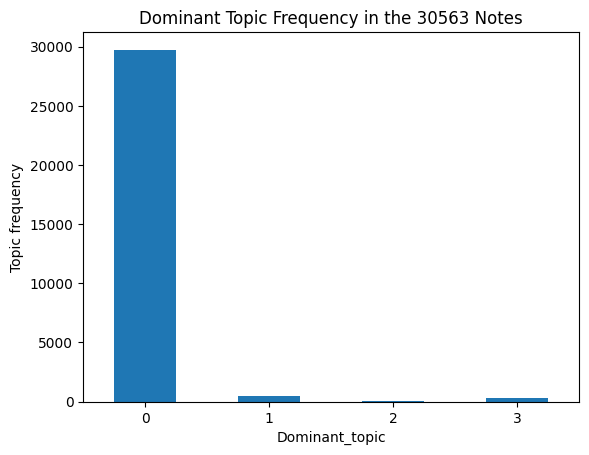

In [36]:
grouped_topics = main_topic_df.groupby('Dominant_topic')
grouped_topics.count()['Processed_text'].\
    plot.bar(rot=0).\
    set(title=f'Dominant Topic Frequency in the {len(df)} Notes',
        ylabel='Topic frequency'); 

Similarly to $k$-means clustering, topic 0 has disproportionally high number of documents.

Let's look at the "most representative" sentence in the data for each topic.

In [37]:
representatives = pd.DataFrame()

for k in grouped_topics.groups.keys():
    representatives = pd.concat([ representatives, 
                                 grouped_topics.get_group(k).sort_values(['Percent'], ascending=False).head(1) ])
    
representatives

,Dominant_topic,Percent,Processed_text,Keywords
29454,0,0.867,"[ship, bangladesh, ship, banglar, samriddh, po...",agricultural car church gas hospital industria...
12519,1,0.904,"[vehicle, voltage, power, line, maintenance, a...",apartment cafe grain healthcare line power sta...
12360,2,0.725,"[outpatient, clinic]",automobile bereznehuvata budling clinic crop k...
215,3,0.786,"[private, house, house, disability]",automobile budling care crop harvested house m...


Let's examine the original text of the representative report for the first topic.

In [38]:
print(f'Document: {representatives.index[0]}  Dominant topic: {representatives.loc[representatives.index[0]]["Dominant_topic"]}\n') 
                    
print(texts[representatives.index[0]])

Document: 29454  Dominant topic: 0

On 2 March 2022, a Russian navy ship fired a missile at Bangladesh-registered civilian ship (Banglar Samriddh) in the Port of Olviya, Mykolaiv. The ship caught on fire. One Bangladeshi member of the crew died.


In [39]:
print(f'Document: {representatives.index[1]}  Dominant topic: {representatives.loc[representatives.index[1]]["Dominant_topic"]}\n')
                        
print(texts[representatives.index[1]])

Document: 12519  Dominant topic: 1

On 21 September 2022, the vehicle of Kharkiv district high voltage power lines maintenance service ran over an anti-tank mine near Hrakove, Kharkiv region, while inspecting the power lines together with Emergency Service sappers. The head of Kharkiv district high voltage power lines maintenance service was killed, two others - injured.


Let's build a histogram of word distributions per topic.

In [40]:
lda_top_words_index = set()
for i in range(lda_model.num_topics):
    lda_top_words_index = lda_top_words_index.union([k for (k,v) in lda_model.get_topic_terms(i)])

print(f'Indices of top words: \n{lda_top_words_index}\n')

Indices of top words: 
{0, 2, 3, 4, 5, 10, 13, 14, 15, 20, 21, 23, 24, 26, 33, 41, 45, 46, 51, 52, 56, 57, 62, 64, 65, 869, 870, 871, 872, 873, 874, 875, 876, 877, 878, 879}



In [41]:
words_we_care_about = [{dictionary[tup[0]]: tup[1] for tup in lst if tup[0] in lda_top_words_index} 
                       for lst in corpus]

In [42]:
lda_top_words_df = pd.DataFrame(words_we_care_about).fillna(0).astype(int).sort_index(axis=1)
lda_top_words_df['Cluster'] = main_topic_df['Dominant_topic']

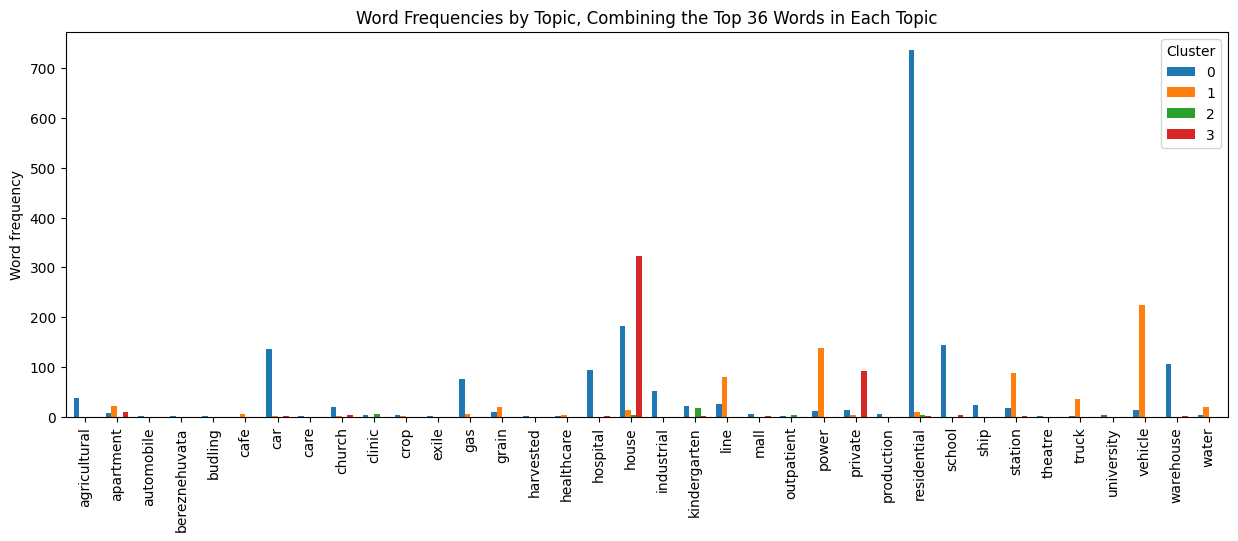

In [43]:
lda_top_words_df.groupby('Cluster').sum().transpose().\
         plot.bar(figsize=(15, 5), width=0.7).\
         set(ylabel='Word frequency', 
         title=f'Word Frequencies by Topic, Combining the Top {len(lda_top_words_index)} Words in Each Topic');

Let's look at the top words found using both $k$-means clustering and LDA. 

In [ ]:
common_words = set(lda_top_words_df.columns[:-1]).intersection(set(word_df.columns[:-1]))

In [ ]:
print(len(common_words))
print(sorted(list(common_words)))

To determine the correct number of topics, I measure the "coherence" of the topics.  Higher coherence scores correspond to "better defined" topics.  

In [ ]:
cm = gensim.models.coherencemodel.CoherenceModel(model=lda_model,
                                                 texts=processed_text,
                                                 dictionary=dictionary)

coherence_scores = [(num_topics, cm.get_coherence())]
print('Coherence score for {} topics:  {}'.format(*coherence_scores[0]))